In [1]:
import numpy as np 
import pandas as pd 
import os
seed = 123
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

from catboost import CatBoostClassifier 
from skopt.space import Real, Categorical, Integer
import tensorflow_addons as tfa
import tensorflow as tf
import matplotlib.pyplot as plt
use_pretrained =  False
use_pca = False

In [2]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/jobathon-analytics-vidhya/sample_submission.csv
/kaggle/input/jobathon-analytics-vidhya/train.csv
/kaggle/input/jobathon-analytics-vidhya/test.csv
/kaggle/input/jobathon/y.csv
/kaggle/input/jobathon/tabnet4_2021-02-27_0.703923581379631.csv
/kaggle/input/jobathon/test.csv
/kaggle/input/jobathon/x.csv


In [3]:
train = pd.read_csv("../input/jobathon-analytics-vidhya/train.csv")
test = pd.read_csv("../input/jobathon-analytics-vidhya/test.csv")
sample = pd.read_csv("../input/jobathon-analytics-vidhya/sample_submission.csv")
train.rename(columns={'Health Indicator': 'Health_Indicator'}, inplace=True)
test.rename(columns={'Health Indicator': 'Health_Indicator'}, inplace=True)
train = train.drop(["ID"], axis=1)
test = test.drop(["ID"], axis=1)
train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [4]:
if use_pretrained:
    train = pd.read_csv('/kaggle/input/jobathon/x.csv')
    test = pd.read_csv('/kaggle/input/jobathon/test.csv')
    y = pd.read_csv('/kaggle/input/jobathon/y.csv')

In [5]:
train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [6]:
cat_cols = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health_Indicator', 
            'Holding_Policy_Duration',  'Holding_Policy_Type', 'Reco_Policy_Cat']
numeric_col = 'Reco_Policy_Premium'
target = 'Response'

In [7]:
scalar = StandardScaler()
train[numeric_col] = scalar.fit_transform(train[numeric_col].values.reshape((-1,1)))
test[numeric_col] = scalar.fit_transform(test[numeric_col].values.reshape((-1,1)))

In [8]:
for col in cat_cols:
    print(f' {col} --> {train[col].nunique()}')

 City_Code --> 36
 Region_Code --> 5316
 Accomodation_Type --> 2
 Reco_Insurance_Type --> 2
 Upper_Age --> 58
 Lower_Age --> 60
 Is_Spouse --> 2
 Health_Indicator --> 9
 Holding_Policy_Duration --> 15
 Holding_Policy_Type --> 4
 Reco_Policy_Cat --> 22


In [9]:
# preparing embedding inputs layers
inputs = []
models = []

def create_mlp(train, cat_cols):

    for col in cat_cols:
        num_of_unique = int(train[col].nunique())
        embedding_size = int(min(np.ceil(num_of_unique/2), 50))
        print(f'{col} unique_value --> {num_of_unique}')
        print(f'{col} embedding size {embedding_size}')

        cat_in = tf.keras.layers.Input(shape=(1,))
        x = tf.keras.layers.Embedding(num_of_unique + 1,embedding_size, name=col )(cat_in)
        x = tf.keras.layers.SpatialDropout1D(0.3)(x)
        out = tf.keras.layers.Reshape(target_shape=(embedding_size,))(x)
        inputs.append(cat_in)
        models.append(out)


    numeric_in = tf.keras.layers.Input(shape=(1,), name='Reco_Policy_Premium')
    out = tf.keras.layers.Dense(2048, activation='relu' )(numeric_in)
    out =  tf.keras.layers.Dense(1024, activation='relu' )(out)
    inputs.append(numeric_in)
    models.append(out)

    # dense layers
    model = tf.keras.layers.Concatenate()(models)

    x = tf.keras.layers.Dense(1024, activation='relu')(model)
    x = tf.keras.layers.Dropout(.35)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(.15)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(.15)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    



    model = tf.keras.Model(inputs, output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
    return model
    print('model compiled')
model = create_mlp(train, cat_cols)

City_Code unique_value --> 36
City_Code embedding size 18
Region_Code unique_value --> 5316
Region_Code embedding size 50
Accomodation_Type unique_value --> 2
Accomodation_Type embedding size 1
Reco_Insurance_Type unique_value --> 2
Reco_Insurance_Type embedding size 1
Upper_Age unique_value --> 58
Upper_Age embedding size 29
Lower_Age unique_value --> 60
Lower_Age embedding size 30
Is_Spouse unique_value --> 2
Is_Spouse embedding size 1
Health_Indicator unique_value --> 9
Health_Indicator embedding size 5
Holding_Policy_Duration unique_value --> 15
Holding_Policy_Duration embedding size 8
Holding_Policy_Type unique_value --> 4
Holding_Policy_Type embedding size 2
Reco_Policy_Cat unique_value --> 22
Reco_Policy_Cat embedding size 11


In [10]:
train_x, test_x, train_y, test_y = train_test_split(train.drop(target, axis=1), train[target], stratify=train[target], random_state=seed, test_size=0.2)
train_x.shape, test.shape

((40705, 12), (21805, 12))

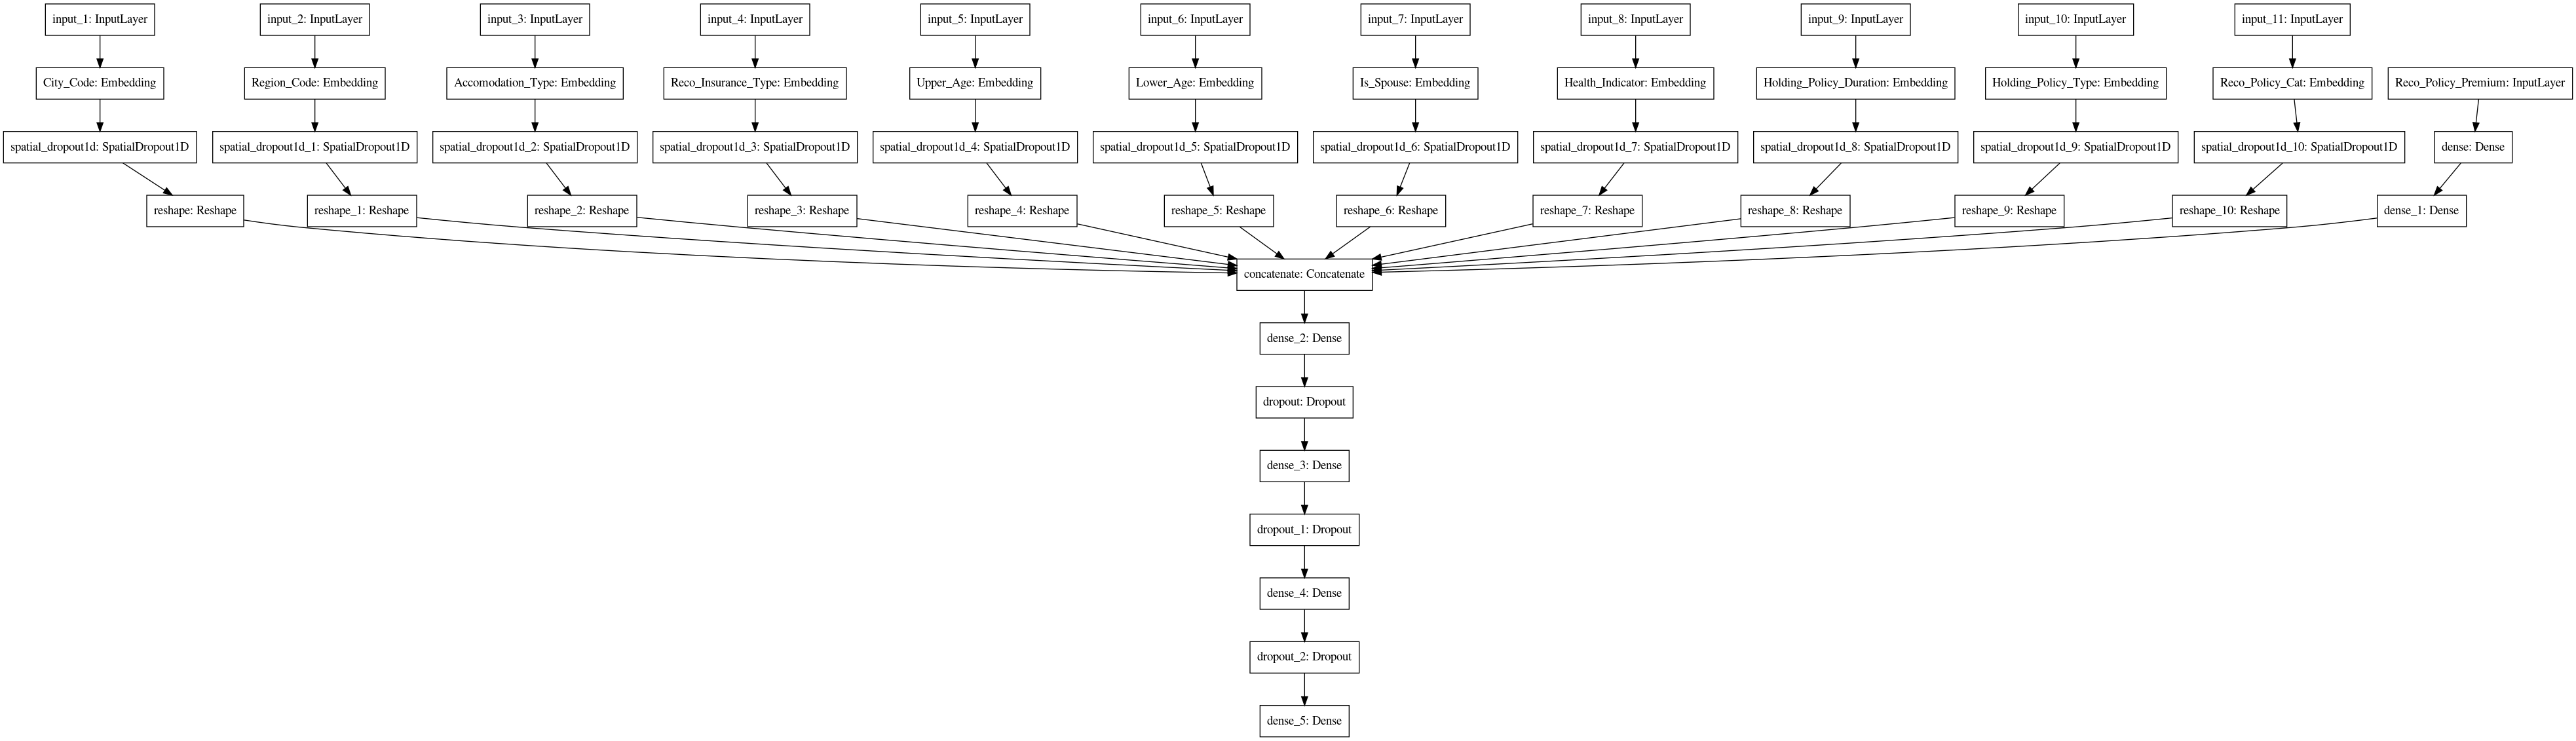

In [11]:
tf.keras.utils.plot_model(model)

In [12]:
if use_pca:
    for i in range(20,76, 5):
        pca = PCA(n_components=i, svd_solver='full')
        pca.fit_transform(train)
        print('components: ',i,'explained variance: ', pca.explained_variance_ratio_.sum() * 100)
    pca =  PCA(n_components=75, svd_solver='full')
    
    transformed = pca.fit_transform(train)

In [13]:
#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in cat_cols:
        raw_vals = X_train[c].unique()
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
#     other_cols = [c for c in X_train.columns if (not c in numeric_col)]
    input_list_train.append(X_train[numeric_col].values)
    input_list_val.append(X_val[numeric_col].values)
    input_list_test.append(X_test[numeric_col].values)
    
    return input_list_train, input_list_val, input_list_test    



In [14]:
train_x, test_x, test = preproc(train_x, test_x, test)

In [15]:
epochs = 200
batch_size = 512


earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=20,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./model.h5', monitor='val_auc', verbose=1, save_best_only=True, mode='max')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=20, min_lr=1e-6, mode='max', verbose=1)

history = model.fit(train_x, train_y.values, 
                    validation_data=(test_x, test_y.values),
                    callbacks=[earlyStopping, reduce_lr_loss, checkpoint],
                    batch_size=batch_size,
                    epochs=500)

Epoch 1/500
80/80 [==============================] - 6s 25ms/step - loss: 0.5701 - auc: 0.5233 - val_loss: 0.5342 - val_auc: 0.6134

Epoch 00001: val_auc improved from -inf to 0.61337, saving model to ./model.h5
Epoch 2/500
80/80 [==============================] - 1s 14ms/step - loss: 0.5188 - auc: 0.6516 - val_loss: 0.5357 - val_auc: 0.6044

Epoch 00002: val_auc did not improve from 0.61337
Epoch 3/500
80/80 [==============================] - 1s 14ms/step - loss: 0.4936 - auc: 0.7180 - val_loss: 0.5392 - val_auc: 0.6104

Epoch 00003: val_auc did not improve from 0.61337
Epoch 4/500
80/80 [==============================] - 1s 14ms/step - loss: 0.4747 - auc: 0.7532 - val_loss: 0.5485 - val_auc: 0.6250

Epoch 00004: val_auc improved from 0.61337 to 0.62502, saving model to ./model.h5
Epoch 5/500
80/80 [==============================] - 1s 14ms/step - loss: 0.4392 - auc: 0.8004 - val_loss: 0.5737 - val_auc: 0.6370

Epoch 00005: val_auc improved from 0.62502 to 0.63702, saving model to ./m

In [16]:
model = tf.keras.models.load_model('./model.h5')


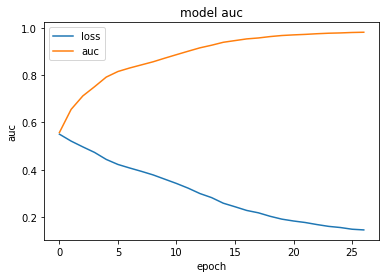

In [17]:
plt.plot(history.history['loss']) 
plt.plot(history.history['auc']) 
plt.title('model auc') 
plt.ylabel('auc')
plt.xlabel('epoch') 
plt.legend(['loss', 'auc'], loc='upper left') 
plt.show()

In [18]:
oof_preds = np.zeros((len(train)))
test_preds = np.zeros((len(test)))

skf = StratifiedKFold(n_splits=50)
for train_index, test_index in skf.split(train_x, train[target].values):
    X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train, y_test = X_train.target.values, X_test.target.values
    train_x, test_x, test = preproc(train_x, test_x, test)
    model = create_model(data, features)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    X_train = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
    X_test = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]
    
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=20,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('./model.h5', monitor='val_auc', verbose=1, save_best_only=True, mode='max')
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=13, min_lr=1e-6, mode='max', verbose=1)
    
    model.fit(X_train,
              utils.to_categorical(y_train),
              validation_data=(X_test, utils.to_categorical(y_test)),
              verbose=1,
              batch_size=1024,
              callbacks=[earlyStopping, checkpoint, reduce_lr_loss],
              epochs=100
             )
    valid_fold_preds = model.predict(X_test)[:, 1]
    test_fold_preds = model.predict(test_data)[:, 1]
    oof_preds[test_index] = valid_fold_preds.ravel()
    test_preds += test_fold_preds.ravel()
    print(metrics.roc_auc_score(y_test, valid_fold_preds))
    K.clear_session()

NameError: name 'StratifiedKFold' is not defined

In [19]:
sub = pd.DataFrame(columns=['ID','Response'])
test_ = pd.read_csv('../input/jobathon/tabnet4_2021-02-27_0.703923581379631.csv')
sub.ID = test_.ID
sub.Response = model.predict(test).reshape(-1,)
sub.head()

,ID,Response
0,50883,0.505611
1,50884,0.077135
2,50885,0.139593
3,50886,0.216910
4,50887,0.065808


In [20]:
sub.to_csv('nn_sub5.csv', index=False)